# LSTM Travel Time + Speed Prediction - Cent.0

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
#traffic = traffic[(traffic['roadName'] == 'Cent.0')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6385,10,54,2021042800
6386,31,15,2021042800
6387,77,32,2021042800
6388,77,32,2021042800
6389,77,33,2021042800
...,...,...,...
294470,77,33,2021051509
294471,44,38,2021051509
294472,64,21,2021051509
294473,31,62,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,60.599444,31.937413
2021042801,60.673611,31.877778
2021042802,59.844228,32.379694
2021042803,60.646732,31.948540
2021042804,60.684722,31.908333
...,...,...
2021051505,58.100139,35.290682
2021051506,58.816412,35.044506
2021051507,58.840056,35.264256


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,0.991345
2021042801,0.998872
2021042802,0.914695
2021042803,0.996144
2021042804,1.000000
...,...
2021051505,0.737680
2021051506,0.810378
2021051507,0.812777


# LSTM - Time

In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 7s 1s/step - loss: 0.5636 - mae: 0.5044 - rmse: 0.5192 - val_loss: 0.0690 - val_mae: 0.0678 - val_rmse: 0.0690
Epoch 2/300
3/3 [==============================] - 0s 81ms/step - loss: 0.3493 - mae: 0.2842 - rmse: 0.3226 - val_loss: 0.0826 - val_mae: 0.0801 - val_rmse: 0.0826
Epoch 3/300
3/3 [==============================] - 0s 68ms/step - loss: 0.3332 - mae: 0.2435 - rmse: 0.2968 - val_loss: 0.2122 - val_mae: 0.2087 - val_rmse: 0.2122
Epoch 4/300
3/3 [==============================] - 0s 66ms/step - loss: 0.3018 - mae: 0.2311 - rmse: 0.2683 - val_loss: 0.1409 - val_mae: 0.1357 - val_rmse: 0.1409
Epoch 5/300
3/3 [==============================] - 0s 70ms/step - loss: 0.3662 - mae: 0.2395 - rmse: 0.3257 - val_loss: 0.1959 - val_mae: 0.1922 - val_rmse: 0.1959
Epoch 6/300
3/3 [==============================] - 0s 72ms/step - loss: 0.4260 - mae: 0.2940 - rmse: 0.3816 - val_loss: 0.1907 - val_mae: 0.1869 - val_rmse: 0.1907
Epoch 7/300
3/3 [=

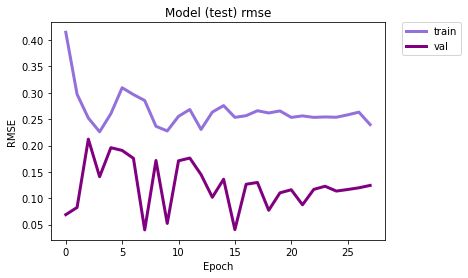

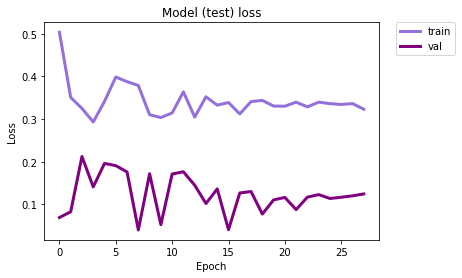

Epoch 1/300
5/5 [==============================] - 0s 72ms/step - loss: 0.2339 - mae: 0.1528 - rmse: 0.2283 - val_loss: 0.1771 - val_mae: 0.1072 - val_rmse: 0.1771
Epoch 2/300
5/5 [==============================] - 0s 51ms/step - loss: 0.2241 - mae: 0.1501 - rmse: 0.2197 - val_loss: 0.1775 - val_mae: 0.1070 - val_rmse: 0.1775
Epoch 3/300
5/5 [==============================] - 0s 53ms/step - loss: 0.2326 - mae: 0.1563 - rmse: 0.2285 - val_loss: 0.1732 - val_mae: 0.1084 - val_rmse: 0.1732
Epoch 4/300
5/5 [==============================] - 0s 56ms/step - loss: 0.2314 - mae: 0.1604 - rmse: 0.2268 - val_loss: 0.1732 - val_mae: 0.1083 - val_rmse: 0.1732
Epoch 5/300
5/5 [==============================] - 0s 58ms/step - loss: 0.2339 - mae: 0.1581 - rmse: 0.2289 - val_loss: 0.1745 - val_mae: 0.1075 - val_rmse: 0.1745
Epoch 6/300
5/5 [==============================] - 0s 60ms/step - loss: 0.2285 - mae: 0.1541 - rmse: 0.2284 - val_loss: 0.1745 - val_mae: 0.1074 - val_rmse: 0.1745
Epoch 7/300
5/5 

Epoch 51/300
5/5 [==============================] - 1s 117ms/step - loss: 0.2272 - mae: 0.1535 - rmse: 0.2229 - val_loss: 0.1721 - val_mae: 0.1033 - val_rmse: 0.1721
Epoch 52/300
5/5 [==============================] - 1s 123ms/step - loss: 0.2252 - mae: 0.1508 - rmse: 0.2251 - val_loss: 0.1720 - val_mae: 0.1032 - val_rmse: 0.1720
Epoch 53/300
5/5 [==============================] - 1s 109ms/step - loss: 0.2250 - mae: 0.1470 - rmse: 0.2253 - val_loss: 0.1725 - val_mae: 0.1030 - val_rmse: 0.1725
Epoch 54/300
5/5 [==============================] - 0s 97ms/step - loss: 0.2243 - mae: 0.1497 - rmse: 0.2176 - val_loss: 0.1727 - val_mae: 0.1029 - val_rmse: 0.1727
Epoch 55/300
5/5 [==============================] - 1s 182ms/step - loss: 0.2286 - mae: 0.1554 - rmse: 0.2267 - val_loss: 0.1742 - val_mae: 0.1031 - val_rmse: 0.1742
Epoch 56/300
5/5 [==============================] - 1s 125ms/step - loss: 0.2186 - mae: 0.1434 - rmse: 0.2167 - val_loss: 0.1746 - val_mae: 0.1031 - val_rmse: 0.1746
Epoch

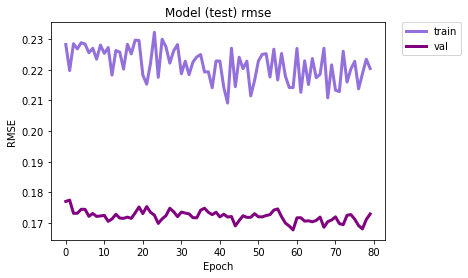

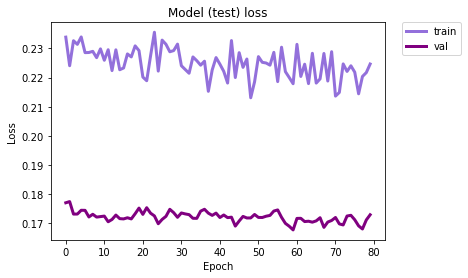

Epoch 1/300
7/7 [==============================] - 1s 78ms/step - loss: 0.2123 - mae: 0.1477 - rmse: 0.2282 - val_loss: 0.2780 - val_mae: 0.1712 - val_rmse: 0.2087
Epoch 2/300
7/7 [==============================] - 0s 64ms/step - loss: 0.2197 - mae: 0.1573 - rmse: 0.2328 - val_loss: 0.2776 - val_mae: 0.1717 - val_rmse: 0.2098
Epoch 3/300
7/7 [==============================] - 0s 64ms/step - loss: 0.2148 - mae: 0.1557 - rmse: 0.2287 - val_loss: 0.2774 - val_mae: 0.1712 - val_rmse: 0.2089
Epoch 4/300
7/7 [==============================] - 0s 53ms/step - loss: 0.2203 - mae: 0.1582 - rmse: 0.2372 - val_loss: 0.2772 - val_mae: 0.1709 - val_rmse: 0.2083
Epoch 5/300
7/7 [==============================] - 0s 53ms/step - loss: 0.2098 - mae: 0.1485 - rmse: 0.2235 - val_loss: 0.2769 - val_mae: 0.1707 - val_rmse: 0.2081
Epoch 6/300
7/7 [==============================] - 0s 55ms/step - loss: 0.2204 - mae: 0.1589 - rmse: 0.2355 - val_loss: 0.2769 - val_mae: 0.1702 - val_rmse: 0.2071
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 59ms/step - loss: 0.2122 - mae: 0.1505 - rmse: 0.2262 - val_loss: 0.2664 - val_mae: 0.1606 - val_rmse: 0.1897
Epoch 52/300
7/7 [==============================] - 0s 52ms/step - loss: 0.2100 - mae: 0.1484 - rmse: 0.2235 - val_loss: 0.2660 - val_mae: 0.1611 - val_rmse: 0.1906
Epoch 53/300
7/7 [==============================] - 0s 77ms/step - loss: 0.2092 - mae: 0.1476 - rmse: 0.2242 - val_loss: 0.2660 - val_mae: 0.1600 - val_rmse: 0.1886
Epoch 54/300
7/7 [==============================] - 0s 59ms/step - loss: 0.2074 - mae: 0.1486 - rmse: 0.2221 - val_loss: 0.2660 - val_mae: 0.1591 - val_rmse: 0.1872
Epoch 55/300
7/7 [==============================] - 0s 51ms/step - loss: 0.2078 - mae: 0.1449 - rmse: 0.2209 - val_loss: 0.2654 - val_mae: 0.1595 - val_rmse: 0.1880
Epoch 56/300
7/7 [==============================] - 1s 67ms/step - loss: 0.2103 - mae: 0.1482 - rmse: 0.2247 - val_loss: 0.2650 - val_mae: 0.1594 - val_rmse: 0.1879
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2007 - mae: 0.1401 - rmse: 0.2155 - val_loss: 0.2527 - val_mae: 0.1439 - val_rmse: 0.1710
Epoch 102/300
7/7 [==============================] - 0s 48ms/step - loss: 0.2017 - mae: 0.1434 - rmse: 0.2176 - val_loss: 0.2527 - val_mae: 0.1429 - val_rmse: 0.1699
Epoch 103/300
7/7 [==============================] - 0s 48ms/step - loss: 0.1963 - mae: 0.1381 - rmse: 0.2124 - val_loss: 0.2521 - val_mae: 0.1431 - val_rmse: 0.1709
Epoch 104/300
7/7 [==============================] - 0s 49ms/step - loss: 0.1949 - mae: 0.1338 - rmse: 0.2062 - val_loss: 0.2514 - val_mae: 0.1436 - val_rmse: 0.1719
Epoch 105/300
7/7 [==============================] - 0s 47ms/step - loss: 0.2001 - mae: 0.1396 - rmse: 0.2126 - val_loss: 0.2515 - val_mae: 0.1420 - val_rmse: 0.1700
Epoch 106/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1995 - mae: 0.1394 - rmse: 0.2120 - val_loss: 0.2508 - val_mae: 0.1422 - val_rmse: 0.1710
Epoc

7/7 [==============================] - 0s 64ms/step - loss: 0.1942 - mae: 0.1298 - rmse: 0.2082 - val_loss: 0.2389 - val_mae: 0.1233 - val_rmse: 0.1623
Epoch 151/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1872 - mae: 0.1264 - rmse: 0.2025 - val_loss: 0.2384 - val_mae: 0.1237 - val_rmse: 0.1633
Epoch 152/300
7/7 [==============================] - 1s 102ms/step - loss: 0.1804 - mae: 0.1255 - rmse: 0.1959 - val_loss: 0.2382 - val_mae: 0.1227 - val_rmse: 0.1624
Epoch 153/300
7/7 [==============================] - 1s 95ms/step - loss: 0.1826 - mae: 0.1208 - rmse: 0.1968 - val_loss: 0.2375 - val_mae: 0.1236 - val_rmse: 0.1641
Epoch 154/300
7/7 [==============================] - 1s 104ms/step - loss: 0.1893 - mae: 0.1338 - rmse: 0.1995 - val_loss: 0.2377 - val_mae: 0.1218 - val_rmse: 0.1607
Epoch 155/300
7/7 [==============================] - 0s 71ms/step - loss: 0.1854 - mae: 0.1248 - rmse: 0.1985 - val_loss: 0.2374 - val_mae: 0.1217 - val_rmse: 0.1606
Epoch 156/300
7/

7/7 [==============================] - 1s 83ms/step - loss: 0.1733 - mae: 0.1134 - rmse: 0.1844 - val_loss: 0.2263 - val_mae: 0.1256 - val_rmse: 0.1567
Epoch 200/300
7/7 [==============================] - 1s 106ms/step - loss: 0.1782 - mae: 0.1230 - rmse: 0.1918 - val_loss: 0.2274 - val_mae: 0.1254 - val_rmse: 0.1531
Epoch 201/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1784 - mae: 0.1195 - rmse: 0.1937 - val_loss: 0.2270 - val_mae: 0.1254 - val_rmse: 0.1548
Epoch 202/300
7/7 [==============================] - 0s 66ms/step - loss: 0.1775 - mae: 0.1171 - rmse: 0.1899 - val_loss: 0.2263 - val_mae: 0.1255 - val_rmse: 0.1567
Epoch 203/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1756 - mae: 0.1165 - rmse: 0.1899 - val_loss: 0.2254 - val_mae: 0.1258 - val_rmse: 0.1597
Epoch 204/300
7/7 [==============================] - 0s 64ms/step - loss: 0.1742 - mae: 0.1201 - rmse: 0.1882 - val_loss: 0.2252 - val_mae: 0.1256 - val_rmse: 0.1584
Epoch 205/300
7/7

7/7 [==============================] - 0s 63ms/step - loss: 0.1723 - mae: 0.1166 - rmse: 0.1861 - val_loss: 0.2169 - val_mae: 0.1296 - val_rmse: 0.1602
Epoch 249/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1626 - mae: 0.1140 - rmse: 0.1774 - val_loss: 0.2165 - val_mae: 0.1293 - val_rmse: 0.1586
Epoch 250/300
7/7 [==============================] - 0s 66ms/step - loss: 0.1629 - mae: 0.1128 - rmse: 0.1718 - val_loss: 0.2168 - val_mae: 0.1291 - val_rmse: 0.1564
Epoch 251/300
7/7 [==============================] - 0s 64ms/step - loss: 0.1636 - mae: 0.1094 - rmse: 0.1747 - val_loss: 0.2170 - val_mae: 0.1291 - val_rmse: 0.1566
Epoch 252/300
7/7 [==============================] - 0s 64ms/step - loss: 0.1624 - mae: 0.1058 - rmse: 0.1735 - val_loss: 0.2155 - val_mae: 0.1298 - val_rmse: 0.1608
Epoch 253/300
7/7 [==============================] - 1s 87ms/step - loss: 0.1595 - mae: 0.1068 - rmse: 0.1696 - val_loss: 0.2147 - val_mae: 0.1306 - val_rmse: 0.1630
Epoch 254/300
7/7 

7/7 [==============================] - 0s 69ms/step - loss: 0.1595 - mae: 0.1057 - rmse: 0.1704 - val_loss: 0.2114 - val_mae: 0.1282 - val_rmse: 0.1531
Epoch 298/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1616 - mae: 0.1084 - rmse: 0.1716 - val_loss: 0.2109 - val_mae: 0.1283 - val_rmse: 0.1536
Epoch 299/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1517 - mae: 0.1039 - rmse: 0.1638 - val_loss: 0.2102 - val_mae: 0.1287 - val_rmse: 0.1550
Epoch 300/300
7/7 [==============================] - 0s 66ms/step - loss: 0.1544 - mae: 0.1040 - rmse: 0.1659 - val_loss: 0.2109 - val_mae: 0.1283 - val_rmse: 0.1526
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


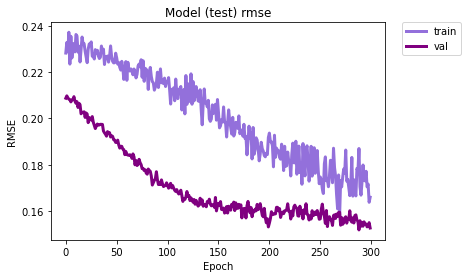

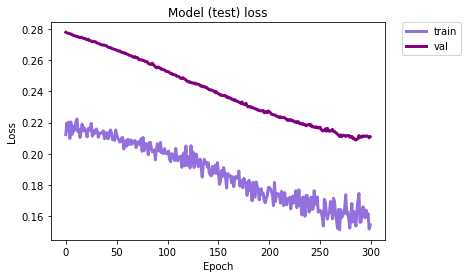

Epoch 1/300
9/9 [==============================] - 1s 60ms/step - loss: 0.1598 - mae: 0.1043 - rmse: 0.1533 - val_loss: 0.1102 - val_mae: 0.0711 - val_rmse: 0.1278
Epoch 2/300
9/9 [==============================] - 1s 58ms/step - loss: 0.1587 - mae: 0.1025 - rmse: 0.1551 - val_loss: 0.1102 - val_mae: 0.0699 - val_rmse: 0.1280
Epoch 3/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1642 - mae: 0.1007 - rmse: 0.1573 - val_loss: 0.1115 - val_mae: 0.0735 - val_rmse: 0.1282
Epoch 4/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1638 - mae: 0.1075 - rmse: 0.1575 - val_loss: 0.1121 - val_mae: 0.0750 - val_rmse: 0.1284
Epoch 5/300
9/9 [==============================] - 1s 66ms/step - loss: 0.1577 - mae: 0.1010 - rmse: 0.1512 - val_loss: 0.1123 - val_mae: 0.0755 - val_rmse: 0.1284
Epoch 6/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1574 - mae: 0.1018 - rmse: 0.1520 - val_loss: 0.1127 - val_mae: 0.0758 - val_rmse: 0.1285
Epoch 7/300
9/9 

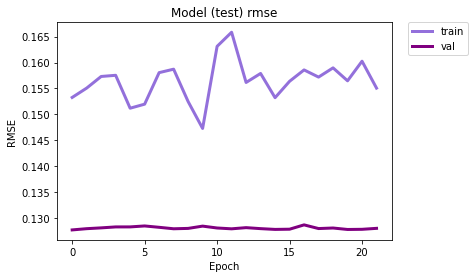

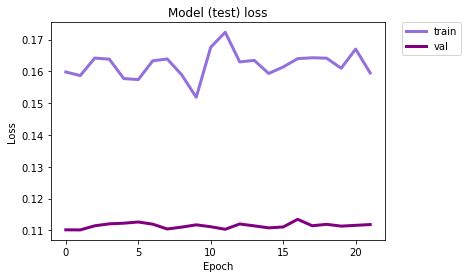

Epoch 1/300
11/11 [==============================] - 1s 72ms/step - loss: 0.1533 - mae: 0.1024 - rmse: 0.1483 - val_loss: 0.2190 - val_mae: 0.1295 - val_rmse: 0.2202
Epoch 2/300
11/11 [==============================] - 1s 91ms/step - loss: 0.1535 - mae: 0.1005 - rmse: 0.1489 - val_loss: 0.2168 - val_mae: 0.1287 - val_rmse: 0.2178
Epoch 3/300
11/11 [==============================] - 1s 84ms/step - loss: 0.1520 - mae: 0.0981 - rmse: 0.1488 - val_loss: 0.2161 - val_mae: 0.1282 - val_rmse: 0.2172
Epoch 4/300
11/11 [==============================] - 1s 75ms/step - loss: 0.1500 - mae: 0.0965 - rmse: 0.1451 - val_loss: 0.2156 - val_mae: 0.1280 - val_rmse: 0.2166
Epoch 5/300
11/11 [==============================] - 1s 82ms/step - loss: 0.1591 - mae: 0.1045 - rmse: 0.1532 - val_loss: 0.2186 - val_mae: 0.1286 - val_rmse: 0.2197
Epoch 6/300
11/11 [==============================] - 1s 86ms/step - loss: 0.1518 - mae: 0.1001 - rmse: 0.1471 - val_loss: 0.2160 - val_mae: 0.1276 - val_rmse: 0.2170
Epoc

11/11 [==============================] - 1s 79ms/step - loss: 0.1519 - mae: 0.0977 - rmse: 0.1457 - val_loss: 0.2127 - val_mae: 0.1242 - val_rmse: 0.2138
Epoch 51/300
11/11 [==============================] - 1s 84ms/step - loss: 0.1547 - mae: 0.1006 - rmse: 0.1502 - val_loss: 0.2140 - val_mae: 0.1245 - val_rmse: 0.2151
Epoch 52/300
11/11 [==============================] - 1s 84ms/step - loss: 0.1507 - mae: 0.0969 - rmse: 0.1465 - val_loss: 0.2112 - val_mae: 0.1227 - val_rmse: 0.2123
Epoch 53/300
11/11 [==============================] - 1s 90ms/step - loss: 0.1467 - mae: 0.0944 - rmse: 0.1426 - val_loss: 0.2118 - val_mae: 0.1234 - val_rmse: 0.2128
Epoch 54/300
11/11 [==============================] - 1s 87ms/step - loss: 0.1484 - mae: 0.0962 - rmse: 0.1429 - val_loss: 0.2113 - val_mae: 0.1233 - val_rmse: 0.2123
Epoch 55/300
11/11 [==============================] - 1s 88ms/step - loss: 0.1534 - mae: 0.0964 - rmse: 0.1477 - val_loss: 0.2080 - val_mae: 0.1220 - val_rmse: 0.2089
Epoch 56/30

11/11 [==============================] - 1s 87ms/step - loss: 0.1517 - mae: 0.0970 - rmse: 0.1463 - val_loss: 0.2062 - val_mae: 0.1194 - val_rmse: 0.2071
Epoch 100/300
11/11 [==============================] - 1s 88ms/step - loss: 0.1513 - mae: 0.0941 - rmse: 0.1483 - val_loss: 0.2100 - val_mae: 0.1210 - val_rmse: 0.2110
Epoch 101/300
11/11 [==============================] - 1s 82ms/step - loss: 0.1482 - mae: 0.0949 - rmse: 0.1431 - val_loss: 0.2093 - val_mae: 0.1206 - val_rmse: 0.2104
Epoch 102/300
11/11 [==============================] - 1s 79ms/step - loss: 0.1505 - mae: 0.0949 - rmse: 0.1453 - val_loss: 0.2048 - val_mae: 0.1191 - val_rmse: 0.2058
Epoch 103/300
11/11 [==============================] - 1s 81ms/step - loss: 0.1466 - mae: 0.0928 - rmse: 0.1405 - val_loss: 0.2067 - val_mae: 0.1196 - val_rmse: 0.2077
Epoch 104/300
11/11 [==============================] - 1s 83ms/step - loss: 0.1529 - mae: 0.0951 - rmse: 0.1476 - val_loss: 0.2087 - val_mae: 0.1202 - val_rmse: 0.2097
Epoch 

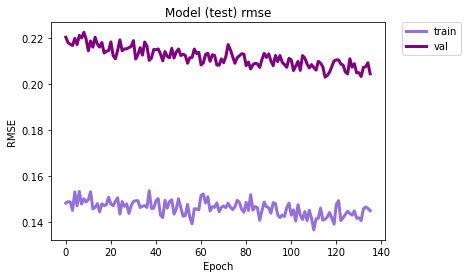

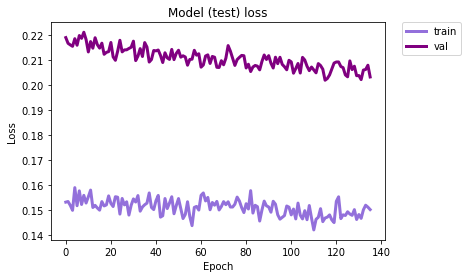

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.7216063
Transformed yhat 43.722095
yhat -0.70609695
Transformed yhat 43.874905
yhat -0.6811728
Transformed yhat 44.120476
yhat -0.65666485
Transformed yhat 44.36195
yhat -0.6505377
Transformed yhat 44.422318
yhat -0.6541723
Transformed yhat 44.386505
yhat -0.65859586
Transformed yhat 44.342922
yhat -0.663776
Transformed yhat 44.291885
yhat -0.6725294
Transformed yhat 44.205635
yhat -0.68217707
Transformed yhat 44.11058
yhat -0.6890885
Transformed yhat 44.04248
yhat -0.6941591
Transformed yhat 43.992527
Real data: [46.50480009 43.7005435  43.5507956  60.68472222 48.50896004 44.62995708
 47.52806722 51.1380993  47.65258585 43.16910123 43.02993335 43.12714853
 43.06411493 43.39453692 43.85680218 42.65496    42.74834219 42.73776218
 43.16290808 42.97621943 42.83216846 42.96075633 44.41042856 43.87661072]
Forecasting values: [43.7, 43.9, 44.1, 44.4, 44.4, 44.4, 44.3, 44.3, 44.2, 44.1, 44.0, 44.0]


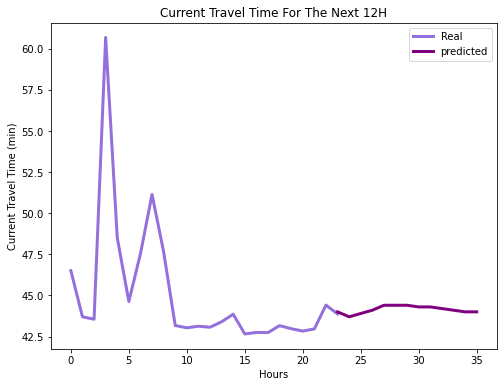

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [19]:
import csv

with open('predictionsTimeGeral.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = forecasts[i],hour[i]
        writer.writerow(d) 

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 10s 1s/step - loss: 0.5981 - mae: 0.5269 - rmse: 0.5443 - val_loss: 0.2309 - val_mae: 0.2306 - val_rmse: 0.2309
Epoch 2/300
3/3 [==============================] - 0s 146ms/step - loss: 0.3813 - mae: 0.2723 - rmse: 0.3476 - val_loss: 0.1707 - val_mae: 0.1704 - val_rmse: 0.1707
Epoch 3/300
3/3 [==============================] - 0s 138ms/step - loss: 0.4823 - mae: 0.3090 - rmse: 0.4313 - val_loss: 0.3703 - val_mae: 0.3701 - val_rmse: 0.3703
Epoch 4/300
3/3 [==============================] - 0s 122ms/step - loss: 0.4043 - mae: 0.3111 - rmse: 0.3647 - val_loss: 0.1488 - val_mae: 0.1484 - val_rmse: 0.1488
Epoch 5/300
3/3 [==============================] - 0s 158ms/step - loss: 0.4548 - mae: 0.2745 - rmse: 0.3994 - val_loss: 0.1940 - val_mae: 0.1936 - val_rmse: 0.1940
Epoch 6/300
3/3 [==============================] - 0s 99ms/step - loss: 0.3716 - mae: 0.2781 - rmse: 0.3278 - val_loss: 0.1150 - val_mae: 0.1146 - val_rmse: 0.1150
Epoch 7/300
3

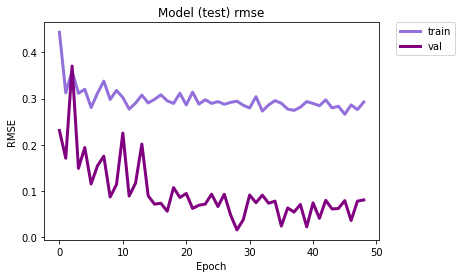

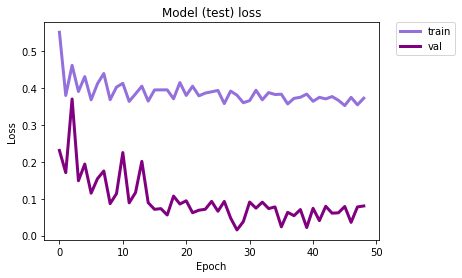

Epoch 1/300
5/5 [==============================] - 0s 74ms/step - loss: 0.2857 - mae: 0.1681 - rmse: 0.2869 - val_loss: 0.2004 - val_mae: 0.1235 - val_rmse: 0.2004
Epoch 2/300
5/5 [==============================] - 0s 61ms/step - loss: 0.2865 - mae: 0.1784 - rmse: 0.2911 - val_loss: 0.1949 - val_mae: 0.1201 - val_rmse: 0.1949
Epoch 3/300
5/5 [==============================] - 0s 64ms/step - loss: 0.2765 - mae: 0.1737 - rmse: 0.2750 - val_loss: 0.1910 - val_mae: 0.1177 - val_rmse: 0.1910
Epoch 4/300
5/5 [==============================] - 0s 70ms/step - loss: 0.2806 - mae: 0.1800 - rmse: 0.2776 - val_loss: 0.1912 - val_mae: 0.1178 - val_rmse: 0.1912
Epoch 5/300
5/5 [==============================] - 0s 62ms/step - loss: 0.2758 - mae: 0.1772 - rmse: 0.2787 - val_loss: 0.1891 - val_mae: 0.1166 - val_rmse: 0.1891
Epoch 6/300
5/5 [==============================] - 0s 64ms/step - loss: 0.2846 - mae: 0.1838 - rmse: 0.2850 - val_loss: 0.1882 - val_mae: 0.1163 - val_rmse: 0.1882
Epoch 7/300
5/5 

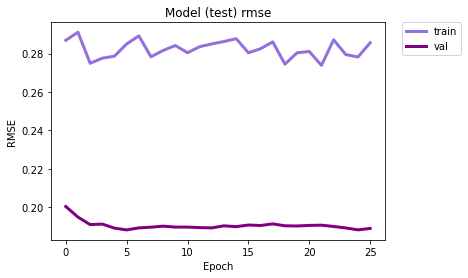

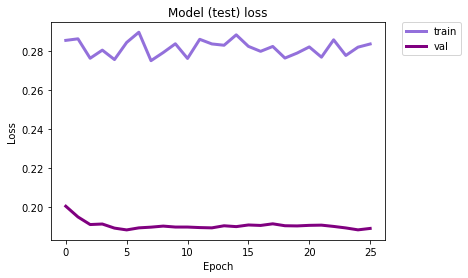

Epoch 1/300
7/7 [==============================] - 1s 90ms/step - loss: 0.2680 - mae: 0.1800 - rmse: 0.2805 - val_loss: 0.3931 - val_mae: 0.2264 - val_rmse: 0.2751
Epoch 2/300
7/7 [==============================] - 1s 79ms/step - loss: 0.2642 - mae: 0.1793 - rmse: 0.2726 - val_loss: 0.3919 - val_mae: 0.2269 - val_rmse: 0.2768
Epoch 3/300
7/7 [==============================] - 0s 65ms/step - loss: 0.2641 - mae: 0.1773 - rmse: 0.2776 - val_loss: 0.3915 - val_mae: 0.2267 - val_rmse: 0.2764
Epoch 4/300
7/7 [==============================] - 1s 91ms/step - loss: 0.2633 - mae: 0.1819 - rmse: 0.2758 - val_loss: 0.3910 - val_mae: 0.2263 - val_rmse: 0.2761
Epoch 5/300
7/7 [==============================] - 1s 80ms/step - loss: 0.2662 - mae: 0.1841 - rmse: 0.2800 - val_loss: 0.3904 - val_mae: 0.2264 - val_rmse: 0.2764
Epoch 6/300
7/7 [==============================] - 1s 79ms/step - loss: 0.2707 - mae: 0.1842 - rmse: 0.2803 - val_loss: 0.3901 - val_mae: 0.2259 - val_rmse: 0.2754
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 1s 81ms/step - loss: 0.2522 - mae: 0.1708 - rmse: 0.2620 - val_loss: 0.3695 - val_mae: 0.2079 - val_rmse: 0.2473
Epoch 52/300
7/7 [==============================] - 1s 86ms/step - loss: 0.2495 - mae: 0.1701 - rmse: 0.2617 - val_loss: 0.3692 - val_mae: 0.2073 - val_rmse: 0.2464
Epoch 53/300
7/7 [==============================] - 1s 82ms/step - loss: 0.2529 - mae: 0.1736 - rmse: 0.2635 - val_loss: 0.3690 - val_mae: 0.2061 - val_rmse: 0.2448
Epoch 54/300
7/7 [==============================] - 1s 81ms/step - loss: 0.2555 - mae: 0.1742 - rmse: 0.2686 - val_loss: 0.3686 - val_mae: 0.2055 - val_rmse: 0.2439
Epoch 55/300
7/7 [==============================] - 1s 76ms/step - loss: 0.2487 - mae: 0.1673 - rmse: 0.2615 - val_loss: 0.3680 - val_mae: 0.2049 - val_rmse: 0.2432
Epoch 56/300
7/7 [==============================] - 1s 82ms/step - loss: 0.2490 - mae: 0.1714 - rmse: 0.2601 - val_loss: 0.3677 - val_mae: 0.2038 - val_rmse: 0.2418
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 1s 95ms/step - loss: 0.2366 - mae: 0.1572 - rmse: 0.2464 - val_loss: 0.3387 - val_mae: 0.1711 - val_rmse: 0.2188
Epoch 102/300
7/7 [==============================] - 1s 92ms/step - loss: 0.2308 - mae: 0.1491 - rmse: 0.2426 - val_loss: 0.3373 - val_mae: 0.1715 - val_rmse: 0.2205
Epoch 103/300
7/7 [==============================] - 1s 89ms/step - loss: 0.2311 - mae: 0.1549 - rmse: 0.2408 - val_loss: 0.3367 - val_mae: 0.1707 - val_rmse: 0.2197
Epoch 104/300
7/7 [==============================] - 1s 87ms/step - loss: 0.2289 - mae: 0.1538 - rmse: 0.2396 - val_loss: 0.3371 - val_mae: 0.1692 - val_rmse: 0.2174
Epoch 105/300
7/7 [==============================] - 1s 90ms/step - loss: 0.2242 - mae: 0.1444 - rmse: 0.2337 - val_loss: 0.3357 - val_mae: 0.1694 - val_rmse: 0.2185
Epoch 106/300
7/7 [==============================] - 1s 91ms/step - loss: 0.2261 - mae: 0.1514 - rmse: 0.2361 - val_loss: 0.3347 - val_mae: 0.1699 - val_rmse: 0.2185
Epoc

7/7 [==============================] - 1s 88ms/step - loss: 0.2093 - mae: 0.1408 - rmse: 0.2181 - val_loss: 0.3106 - val_mae: 0.1778 - val_rmse: 0.2141
Epoch 151/300
7/7 [==============================] - 1s 86ms/step - loss: 0.2097 - mae: 0.1358 - rmse: 0.2219 - val_loss: 0.3108 - val_mae: 0.1769 - val_rmse: 0.2124
Epoch 152/300
7/7 [==============================] - 1s 97ms/step - loss: 0.2092 - mae: 0.1398 - rmse: 0.2185 - val_loss: 0.3101 - val_mae: 0.1767 - val_rmse: 0.2125
Epoch 153/300
7/7 [==============================] - 1s 88ms/step - loss: 0.2065 - mae: 0.1356 - rmse: 0.2198 - val_loss: 0.3102 - val_mae: 0.1759 - val_rmse: 0.2118
Epoch 154/300
7/7 [==============================] - 1s 83ms/step - loss: 0.2021 - mae: 0.1359 - rmse: 0.2149 - val_loss: 0.3085 - val_mae: 0.1771 - val_rmse: 0.2132
Epoch 155/300
7/7 [==============================] - 1s 92ms/step - loss: 0.2034 - mae: 0.1321 - rmse: 0.2173 - val_loss: 0.3094 - val_mae: 0.1756 - val_rmse: 0.2115
Epoch 156/300
7/7 

7/7 [==============================] - 1s 91ms/step - loss: 0.1989 - mae: 0.1330 - rmse: 0.2073 - val_loss: 0.2927 - val_mae: 0.1781 - val_rmse: 0.2138
Epoch 200/300
7/7 [==============================] - 1s 90ms/step - loss: 0.1953 - mae: 0.1346 - rmse: 0.2072 - val_loss: 0.2954 - val_mae: 0.1737 - val_rmse: 0.2073
Epoch 201/300
7/7 [==============================] - 1s 83ms/step - loss: 0.1925 - mae: 0.1321 - rmse: 0.2054 - val_loss: 0.2957 - val_mae: 0.1728 - val_rmse: 0.2058
Epoch 202/300
7/7 [==============================] - 1s 87ms/step - loss: 0.2048 - mae: 0.1300 - rmse: 0.2123 - val_loss: 0.2942 - val_mae: 0.1747 - val_rmse: 0.2088
Epoch 203/300
7/7 [==============================] - 1s 85ms/step - loss: 0.1945 - mae: 0.1301 - rmse: 0.2040 - val_loss: 0.2939 - val_mae: 0.1746 - val_rmse: 0.2084
Epoch 204/300
7/7 [==============================] - 1s 77ms/step - loss: 0.2040 - mae: 0.1364 - rmse: 0.2204 - val_loss: 0.2958 - val_mae: 0.1721 - val_rmse: 0.2050
Epoch 205/300
7/7 

7/7 [==============================] - 1s 94ms/step - loss: 0.1887 - mae: 0.1250 - rmse: 0.2040 - val_loss: 0.2873 - val_mae: 0.1693 - val_rmse: 0.2008
Epoch 249/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1813 - mae: 0.1221 - rmse: 0.1970 - val_loss: 0.2870 - val_mae: 0.1698 - val_rmse: 0.2019
Epoch 250/300
7/7 [==============================] - 1s 100ms/step - loss: 0.1921 - mae: 0.1296 - rmse: 0.2101 - val_loss: 0.2876 - val_mae: 0.1698 - val_rmse: 0.2016
Epoch 251/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1887 - mae: 0.1243 - rmse: 0.2022 - val_loss: 0.2874 - val_mae: 0.1703 - val_rmse: 0.2027
Epoch 252/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1913 - mae: 0.1306 - rmse: 0.2075 - val_loss: 0.2884 - val_mae: 0.1691 - val_rmse: 0.2005
Epoch 253/300
7/7 [==============================] - 1s 92ms/step - loss: 0.1901 - mae: 0.1237 - rmse: 0.2049 - val_loss: 0.2886 - val_mae: 0.1687 - val_rmse: 0.1996
Epoch 254/300
7/7

7/7 [==============================] - 1s 118ms/step - loss: 0.1887 - mae: 0.1232 - rmse: 0.2019 - val_loss: 0.2818 - val_mae: 0.1688 - val_rmse: 0.2002
Epoch 298/300
7/7 [==============================] - 1s 88ms/step - loss: 0.1884 - mae: 0.1281 - rmse: 0.1995 - val_loss: 0.2813 - val_mae: 0.1687 - val_rmse: 0.1996
Epoch 299/300
7/7 [==============================] - 1s 80ms/step - loss: 0.1909 - mae: 0.1297 - rmse: 0.2081 - val_loss: 0.2829 - val_mae: 0.1679 - val_rmse: 0.1984
Epoch 300/300
7/7 [==============================] - 1s 91ms/step - loss: 0.1873 - mae: 0.1244 - rmse: 0.2024 - val_loss: 0.2815 - val_mae: 0.1686 - val_rmse: 0.1995
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


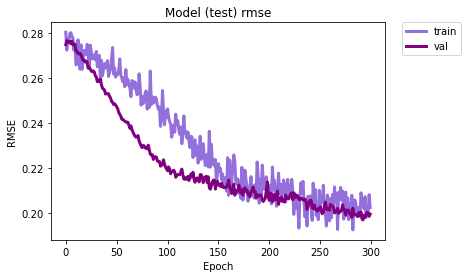

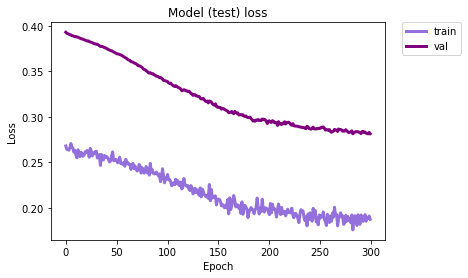

Epoch 1/300
9/9 [==============================] - 1s 96ms/step - loss: 0.1895 - mae: 0.1240 - rmse: 0.1847 - val_loss: 0.1228 - val_mae: 0.0815 - val_rmse: 0.1437
Epoch 2/300
9/9 [==============================] - 1s 82ms/step - loss: 0.1983 - mae: 0.1232 - rmse: 0.1889 - val_loss: 0.1228 - val_mae: 0.0812 - val_rmse: 0.1438
Epoch 3/300
9/9 [==============================] - 1s 86ms/step - loss: 0.1858 - mae: 0.1137 - rmse: 0.1764 - val_loss: 0.1245 - val_mae: 0.0841 - val_rmse: 0.1444
Epoch 4/300
9/9 [==============================] - 1s 83ms/step - loss: 0.1947 - mae: 0.1199 - rmse: 0.1843 - val_loss: 0.1268 - val_mae: 0.0886 - val_rmse: 0.1454
Epoch 5/300
9/9 [==============================] - 1s 81ms/step - loss: 0.1885 - mae: 0.1188 - rmse: 0.1811 - val_loss: 0.1263 - val_mae: 0.0874 - val_rmse: 0.1452
Epoch 6/300
9/9 [==============================] - 1s 97ms/step - loss: 0.1946 - mae: 0.1182 - rmse: 0.1865 - val_loss: 0.1236 - val_mae: 0.0815 - val_rmse: 0.1444
Epoch 7/300
9/9 

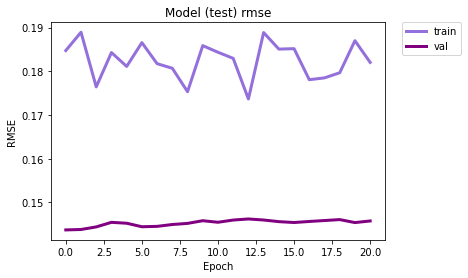

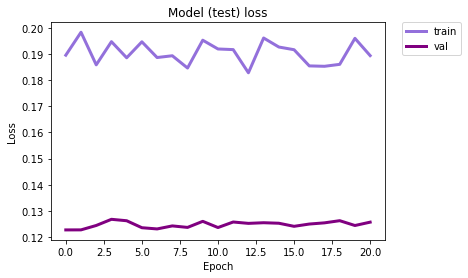

Epoch 1/300
11/11 [==============================] - 1s 89ms/step - loss: 0.1877 - mae: 0.1181 - rmse: 0.1815 - val_loss: 0.2603 - val_mae: 0.1472 - val_rmse: 0.2596
Epoch 2/300
11/11 [==============================] - 1s 84ms/step - loss: 0.1835 - mae: 0.1170 - rmse: 0.1817 - val_loss: 0.2607 - val_mae: 0.1470 - val_rmse: 0.2599
Epoch 3/300
11/11 [==============================] - 1s 86ms/step - loss: 0.1858 - mae: 0.1151 - rmse: 0.1815 - val_loss: 0.2578 - val_mae: 0.1457 - val_rmse: 0.2570
Epoch 4/300
11/11 [==============================] - 1s 93ms/step - loss: 0.1870 - mae: 0.1180 - rmse: 0.1812 - val_loss: 0.2620 - val_mae: 0.1480 - val_rmse: 0.2613
Epoch 5/300
11/11 [==============================] - 1s 87ms/step - loss: 0.1774 - mae: 0.1093 - rmse: 0.1702 - val_loss: 0.2619 - val_mae: 0.1479 - val_rmse: 0.2612
Epoch 6/300
11/11 [==============================] - 1s 85ms/step - loss: 0.1783 - mae: 0.1088 - rmse: 0.1722 - val_loss: 0.2585 - val_mae: 0.1459 - val_rmse: 0.2577
Epoc

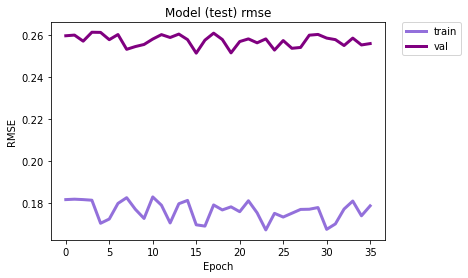

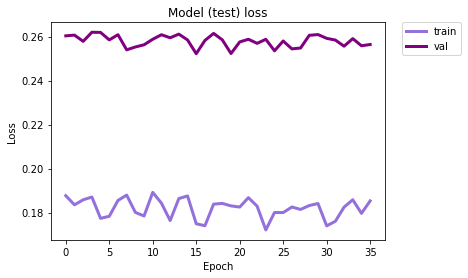

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.7361714
Transformed yhat 58.085274
yhat 0.75309336
Transformed yhat 58.252003
yhat 0.75190073
Transformed yhat 58.240253
yhat 0.74115205
Transformed yhat 58.134346
yhat 0.73039114
Transformed yhat 58.02832
yhat 0.7246088
Transformed yhat 57.97135
yhat 0.7239886
Transformed yhat 57.96524
yhat 0.72628427
Transformed yhat 57.987858
yhat 0.7291001
Transformed yhat 58.015606
yhat 0.7309506
Transformed yhat 58.033833
yhat 0.73151284
Transformed yhat 58.03937
yhat 0.7313988
Transformed yhat 58.03825
Real data: [54.90833333 57.75382476 58.07788595 50.16133519 54.20416667 56.59248957
 52.32823366 48.03333333 52.37969402 58.36995828 58.69680111 58.62916667
 58.73296245 58.38664812 58.35465925 59.03333333 58.7232267  58.91794159
 58.71944444 58.10013908 58.81641168 58.84005563 57.4875     57.7477314 ]
Forecasting values: [58.1, 58.3, 58.2, 58.1, 58.0, 58.0, 58.0, 58.0, 58.0, 58.0, 58.0, 58.0]


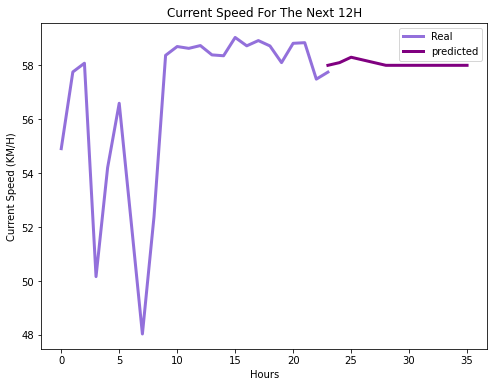

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [24]:
import csv

with open('predictionsSpeedGeral.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = forecastSpeed[i],hour[i]
        writer.writerow(d)